<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px" />

# Lab: Titanic EDA

---
For this lab, we're going to take a look at the Titanic manifest. We'll be exploring this data to see what we can learn regarding the survival rates of different groups of people.

## Step 1: Reading the data

1. Read the titanic data (in the form of the `train.csv` in this repo using the appropriate Pandas method).

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [77]:
train = pd.read_csv("train.csv")

In [78]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [79]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [80]:
train.info()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [81]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [82]:
train.shape

(891, 12)

In [83]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

### Data Dictionary

| Variable | Description | Details |
|----------|-------------|---------|
| survival | Survival | 0 = No; 1 = Yes |
| pclass | Passenger Class | 1 = 1st; 2 = 2nd; 3 = 3rd |
| name | First and Last Name | |
| sex | Sex | |
| age | Age | |
| sibsp | Number of Siblings/Spouses Aboard | |
| parch | Number of Parents/Children Aboard | |
| ticket | Ticket Number | |
| fare | Passenger Fare | |
| cabin | Cabin | |
| embarked | Port of Embarkation | C = Cherbourg; Q = Queenstown; S = Southampton |

## Step 2: Cleaning the data
####  1. Create a bar chart showing how many missing values are in each column

<Axes: >

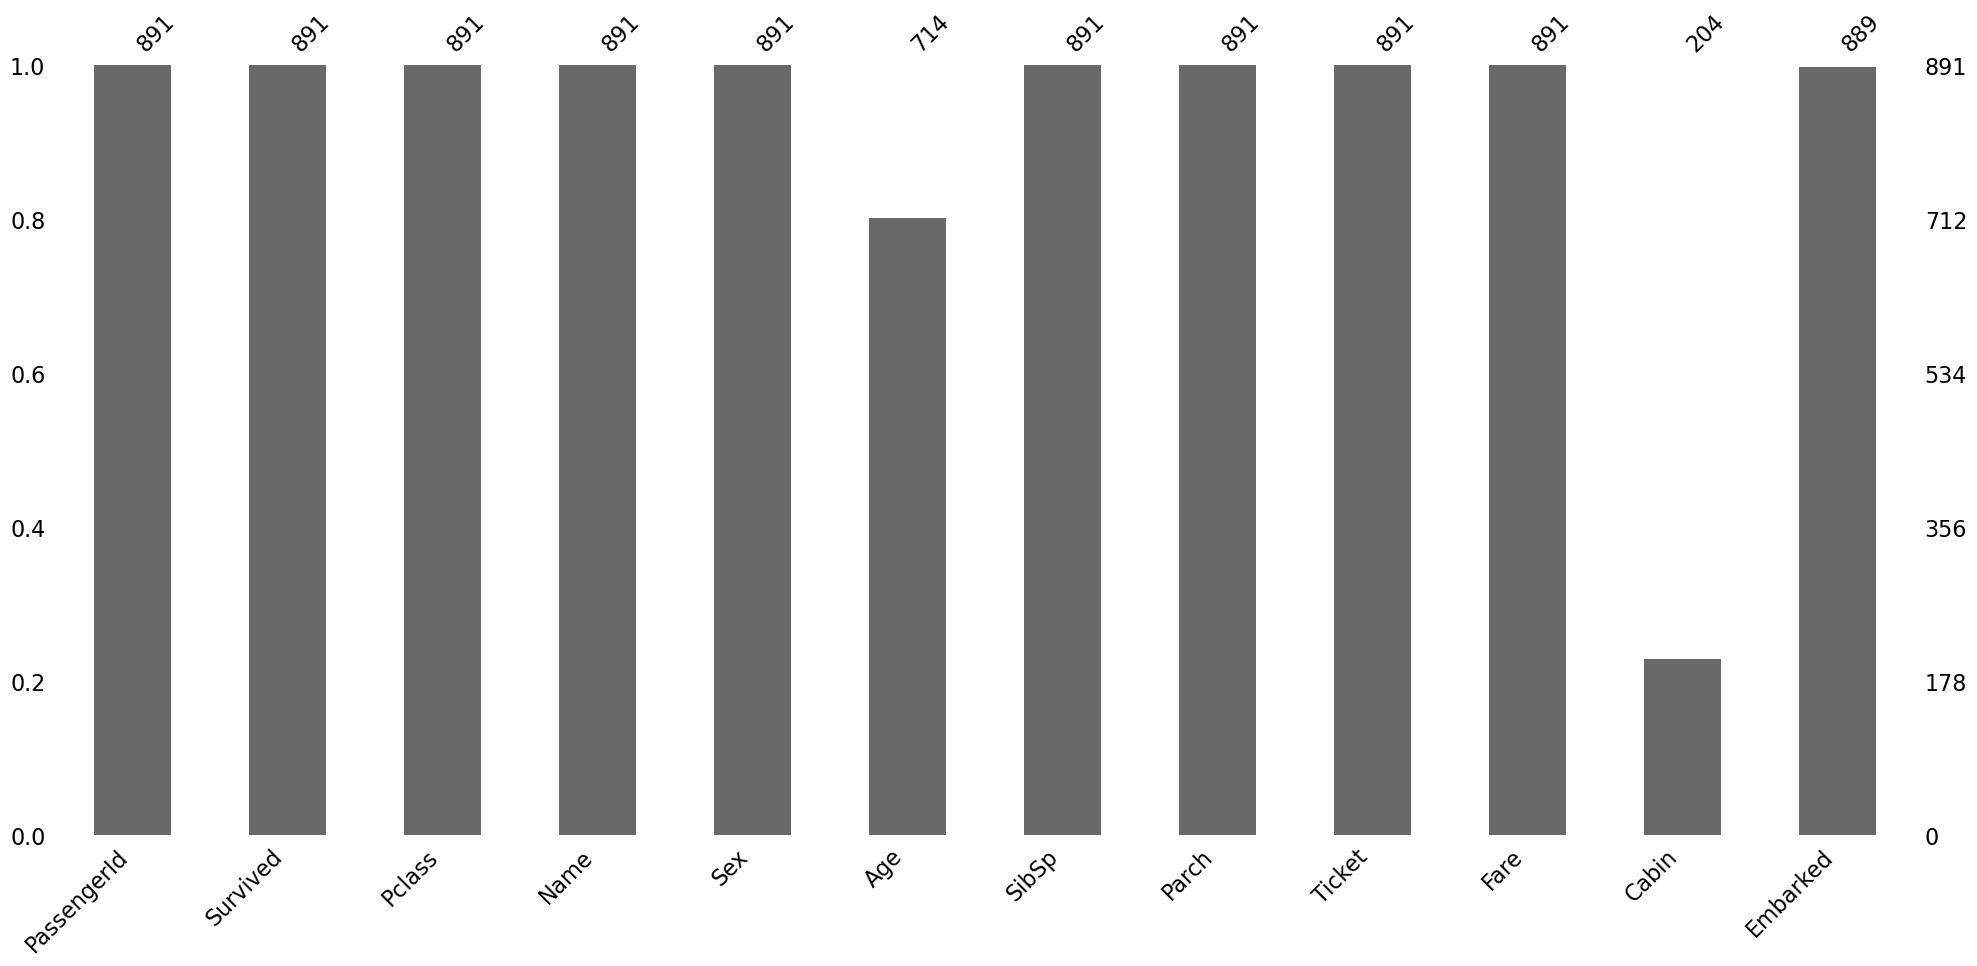

In [86]:
msno.bar(train.sample(891))

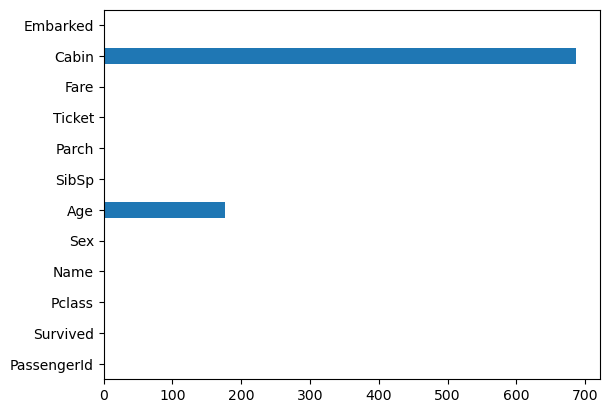

In [87]:
#why this method? because cleaner look and less stimuli overload
train.isnull().sum().plot(kind='barh')
plt.show()

#train.isnull().sum()[train.isnull().sum() !=0].plot(kind='barh') #This achieved that only the 3 columns (Age, Embarked, and Cabins) have nulls for a clerner graph.

In [88]:
#assigning code to a variable pros and cons
#we use it later or use the output repeatedly, but if you're not, more keystrokes, time spent. We got many variables in the namespace.
#output expressed in the notebook like missing_values. 

missing_values = train.isnull().sum()
missing_values 

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

####  2. Which column has the most `NaN` values? How many cells in that column are empty?


In [90]:
#train.isnull().sum() 
missing_values = train.isnull().sum().sort_values(ascending = False)
missing_values # Answer: The 'Cabin' column has the most NaNs = 687.

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

####  3. Delete all rows where `Embarked` is empty

In [92]:
train = train.dropna(subset=['Embarked']).reset_index(drop=True)
#or train = train.dropna(subset=['Embarked'], inplace=True) 

In [93]:
train['Embarked'].isnull().sum() #check

0

#### 4. Fill all empty cabins with **¯\\_(ツ)_/¯**

Note: `NaN`, empty, and missing are synonymous.

In [95]:
train['Cabin'] = train['Cabin'].fillna("¯\\_(ツ)_/¯")
#or train.fillna({'Cabin': r"¯\\_(ツ)_/¯"}, inplace=True) no warnings no errors

In [96]:
train['Cabin'].isnull().sum() #check or train['Cabin'].value_counts() #idxmax()

0

## Step 3: Feature extraction

#### 1.  There are two columns that pertain to how many family members are on the boat for a given person. Create a new column called `FamilyCount` which will be the sum of those two columns.

In [99]:
train['FamilyCount'] = train['SibSp'] + train['Parch']

In [100]:
train[['Parch', 'SibSp', 'FamilyCount']] #to check for silent errors

,Parch,SibSp,FamilyCount
0,0,1,1
1,0,1,1
2,0,0,0
3,0,1,1
4,0,0,0
...,...,...,...
884,0,0,0
885,0,0,0
886,2,1,3
887,0,0,0


In [101]:
train.info() #check

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          712 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Cabin        889 non-null    object 
 11  Embarked     889 non-null    object 
 12  FamilyCount  889 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.4+ KB


#### 2. Reverends have a special title in their name. Create a column called `IsReverend`: 1 if they're a preacher, 0 if they're not.


In [103]:
train['Name'].unique()

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina',
       'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
       'Allen, Mr. William Henry', 'Moran, Mr. James',
       'McCarthy, Mr. Timothy J', 'Palsson, Master. Gosta Leonard',
       'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)',
       'Nasser, Mrs. Nicholas (Adele Achem)',
       'Sandstrom, Miss. Marguerite Rut', 'Bonnell, Miss. Elizabeth',
       'Saundercock, Mr. William Henry', 'Andersson, Mr. Anders Johan',
       'Vestrom, Miss. Hulda Amanda Adolfina',
       'Hewlett, Mrs. (Mary D Kingcome) ', 'Rice, Master. Eugene',
       'Williams, Mr. Charles Eugene',
       'Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)',
       'Masselmani, Mrs. Fatima', 'Fynney, Mr. Joseph J',
       'Beesley, Mr. Lawrence', 'McGowan, Miss. Anna "Annie"',
       'Sloper, Mr. William Thompson', 'Palsson, Miss. Torborg Danira',
       'Asplund, Mrs. Carl Oscar 

In [104]:
train['IsReverend'] = train['Name'].apply(lambda x: 1 if 'Rev.' in x else 0)

# alternative answer: train['IsReverend'] = train['Name'].str.contains('Rev').map(lambdax: int(x))
#check train[train['IsReverend'] ==1] or train['IsReverend'].value_counts()

In [105]:
train['IsReverend'].value_counts() #6 people are Reverends

IsReverend
0    883
1      6
Name: count, dtype: int64

#### 3. In order to feed our training data into a classification algorithm, we need to convert our categories into 1's and 0's using `pd.get_dummies`.

  - Familiarize yourself with the [**`pd.get_dummies` documentation**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html)
  - Create 3 columns: `Embarked_C`, `Embarked_Q` and `Embarked_S`. These columns will have 1's and 0's that correspond to the `C`, `Q` and `S` values in the `Embarked` column
  - Do the same thing for `Sex`
  - BONUS (required): Extract the title from everyone's name and create dummy columns

In [107]:
train['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [108]:
#answer in-class this option removes the original column
#train = pd.get_dummies(train, columns=['Embarked'])

In [109]:
#answer in-class train = pd.get_dummies(train, columns=['Sex']) or train['is_male'] = train['Sex'].map(lamda x:1 if x == 'male' else) then check train[is_male].value_counts()

In [110]:
# to create dummy variables 
embarked_dummies = pd.get_dummies(train['Embarked'], prefix='Embarked', dtype=int)
# to merge the dummy variables to the original df train.
train = pd.concat([train, embarked_dummies], axis=1) 

In [111]:
train.head() #check

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilyCount,IsReverend,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,¯\_(ツ)_/¯,S,1,0,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,¯\_(ツ)_/¯,S,0,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,¯\_(ツ)_/¯,S,0,0,0,0,1


In [112]:
#alternative answer: train['Title'] = [each.split(',')[1].split('.')etc...

In [113]:
# Extract titles from the Name column
train['Title'] = train['Name'].str.extract('([A-Za-z]+)\\.', expand=False)
 
# Create dummy variables for Sex
sex_dummies = pd.get_dummies(train['Sex'], prefix='Sex', dtype=int)

# Create dummy variables for Title
title_dummies = pd.get_dummies(train['Title'], prefix='Title', dtype=int)

# Merge the dummy variables with the original DataFrame
train = pd.concat([train, sex_dummies, title_dummies], axis=1)

In [114]:
train.columns #check work

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'FamilyCount',
       'IsReverend', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title',
       'Sex_female', 'Sex_male', 'Title_Capt', 'Title_Col', 'Title_Countess',
       'Title_Don', 'Title_Dr', 'Title_Jonkheer', 'Title_Lady', 'Title_Major',
       'Title_Master', 'Title_Miss', 'Title_Mlle', 'Title_Mme', 'Title_Mr',
       'Title_Mrs', 'Title_Ms', 'Title_Rev', 'Title_Sir'],
      dtype='object')

## Step 4: Exploratory analysis

_[`df.groupby()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) may be very useful._

#### 1. What was the survival rate overall?


In [118]:
survival_rate = round(train['Survived'].mean()*100,2) 
survival_rate
#Answer: the percentage is 38.25%.

38.25

#### 2. Which gender fared the worst? What was their survival rate?

In [120]:
#Ans: 'Sex_male' 1 = the person is a male
male_survived = round(train.groupby('Sex_male')[['Survived']].mean()*100, 2)
male_survived

,Survived
Sex_male,
0,74.04
1,18.89


In [121]:
print(f"The males fared the worst. Only 18% males survived.")

The males fared the worst. Only 18% males survived.


#### 3. What was the survival rate for each `Pclass`?

In [123]:
#Ans in-class: train['Pclass'].unique()
train.groupby('Pclass')[['Survived']].mean()


#My own anwer : get_titanic_class = train[['Survived', 'Pclass']].groupby(['Pclass']).mean()
#get_titanic_class


#ans: train.groupby('Pclass')[['Sex_male', 'Survived']].mean()
#ans: train.groupby(['Pclass', 'Sex_male'])[['Survived']].mean()
#ans: train.groupby(['Pclass', 'Sex_male'])[['Fare', 'Survived']].mean()
#analysis overall survival rate 38%

#survival rate by gender is : women higher percentage of survival than men
#survival rate by class and gender is: higher women in each class, difference in classes, first class survival is the best (higher than 2nd, 3rd)
#women interestingly on average paid more for their tickets and the fare gap was largest in first class

,Survived
Pclass,
1,0.626168
2,0.472826
3,0.242363


#### 4. Did any reverends survive? How many?`

In [125]:
reverends = train[train['Name'].str.contains('Rev.')]

reverends_survived = reverends[reverends['Survived'] == 1]

# Get the number of reverends who survived
num_reverends_survived = reverends_survived.shape[0]
num_reverends_survived # Answer: nobody as a Rev. survived

#answer in-class: train.groupby('isrevered')[['survived']].mean() ,also check train[train['isrevered']==1][['survived']]
#check if they were male train[(train['isrev']==1) & (train['ismale] ==1)][['ismale', 'survived']]

0

#### 5. What is the survival rate for cabins marked **¯\\_(ツ)_/¯**

In [127]:
train[train['Cabin'] == r"¯\_(ツ)_/¯"][['Survived']].mean()

Survived    0.299854
dtype: float64

In [128]:
#Answer: 
print(f"The survival rate for marked cabins is 29%.")

The survival rate for marked cabins is 29%.


#### 6. What is the survival rate for people whose `Age` is empty?

In [130]:
train[train['Age'].isnull()]['Survived'].mean()
#Answer: 29.37%

0.2937853107344633

####  7. What is the survival rate for each port of embarkation?

In [132]:
for col in ['Embarked_C', 'Embarked_Q','Embarked_S']:
    print(col, ":")
    print(train[train[col] ==1][['Survived']].mean())

#Answer: Embarked C: 55%, Embarked Q: 38%, Embarked S: 33%

Embarked_C :
Survived    0.553571
dtype: float64
Embarked_Q :
Survived    0.38961
dtype: float64
Embarked_S :
Survived    0.336957
dtype: float64


#### 8. What is the survival rate for children (under 12) in each `Pclass`?

In [134]:
train[train['Age'] <12].groupby('Pclass')[['Survived']].mean()

,Survived
Pclass,
1,0.750000
2,1.000000
3,0.404255


####  9. Did the captain of the ship survive? Is he on the list?

In [136]:
captain = train[train['Name'].str.contains('Capt.')]

In [137]:
captain

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir
744,746,0,1,"Crosby, Capt. Edward Gifford",male,70.0,1,1,WE/P 5735,71.0,...,0,0,0,0,0,0,0,0,0,0


In [138]:
#Answer: 
print(f"One captain's name was Crosby, Capt. Edward Gifford and he did not survive.") 

#The actual captain's name was Edward was a different name. and was not accounted for and believed to have died.
# in-class alternative answer we mask with this: train[train['Name'].str.contains('Capt.')][['Name', 'Survived']]

One captain's name was Crosby, Capt. Edward Gifford and he did not survive.


#### 10. Of all the people that died, who had the most expensive ticket? How much did it cost?

In [140]:
train[train['Survived'] == 0].describe() #Fare max = 263 USD/Pounds Sterling

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilyCount,IsReverend,Embarked_C,...,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir
count,549.000000,549.0,549.000000,424.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,...,549.000000,549.000000,549.000000,549.0,549.0,549.000000,549.000000,549.0,549.000000,549.0
mean,447.016393,0.0,2.531876,30.626179,0.553734,0.329690,22.117887,0.883424,0.010929,0.136612,...,0.001821,0.030965,0.100182,0.0,0.0,0.794171,0.047359,0.0,0.010929,0.0
std,260.640469,0.0,0.735805,14.172110,1.288399,0.823166,31.388207,1.830669,0.104064,0.343751,...,0.042679,0.173382,0.300517,0.0,0.0,0.404675,0.212599,0.0,0.104064,0.0
min,1.000000,0.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
25%,211.000000,0.0,2.000000,21.000000,0.000000,0.000000,7.854200,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0,0.000000,0.0
50%,455.000000,0.0,3.000000,28.000000,0.000000,0.000000,10.500000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0,0.000000,0.0
75%,675.000000,0.0,3.000000,39.000000,1.000000,0.000000,26.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0,0.000000,0.0
max,891.000000,0.0,3.000000,74.000000,8.000000,6.000000,263.000000,10.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,0.0,1.000000,0.0


In [141]:
train[(train['Survived'] == 0) & (train['Fare']==263)] # 2 people with the highest fare. Name: Fortune, Mr. Charles Alexander and Fortune, Mr. Mark
#answer train[train['Survived'] == 0].sort_values(by="Fare",ascending=False).head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0,...,0,0,0,0,0,1,0,0,0,0
437,439,0,1,"Fortune, Mr. Mark",male,64.0,1,4,19950,263.0,...,0,0,0,0,0,1,0,0,0,0


In [142]:
deaths = train[train['Survived'] == 0] #df filtered just the deaths i.e. survived =0 

In [143]:
deaths['Fare'].max()

263.0

#### 11. Does having family on the boat help or hurt your chances of survival?

In [145]:
#Please help :)

train[['FamilyCount', 'Survived']].value_counts() 

# It appears that by being alone (FamilyCount =0) your chances of dying increases.
#374 people died alone (FamilyCount=0) compared to deaths lower than 72 for 1,2 3, 4, 5, etc. family members.

FamilyCount  Survived
0            0           374
             1           161
1            1            89
             0            72
2            1            59
             0            43
3            1            21
5            0            19
4            0            12
3            0             8
6            0             8
10           0             7
7            0             6
6            1             4
4            1             3
5            1             3
Name: count, dtype: int64

In [146]:
singles_survived = (161/340)*100
print(f"The survival rate for single people is {singles_survived:.2f}%, which is the highest percentage of the deaths, and it seems having a family increases your chance of survival.")

The survival rate for single people is 47.35%, which is the highest percentage of the deaths, and it seems having a family increases your chance of survival.


## Step 5: Plotting
Using Matplotlib and Seaborn, create multiple charts showing the survival rates of different groups of people. It's fine if a handful of charts are basic (Gender, Age, etc), but what we're really looking for is something beneath the surface.


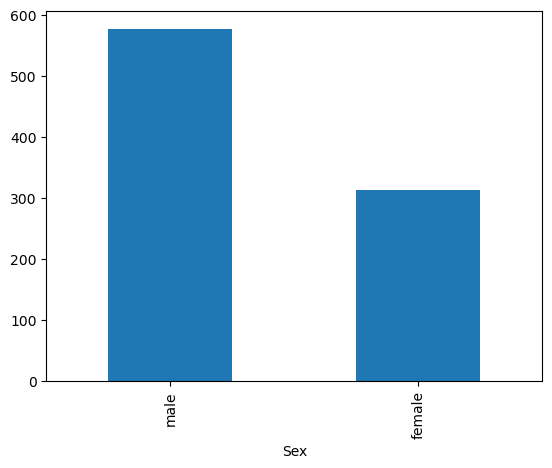

In [148]:
train['Sex'].value_counts().plot(kind='bar');

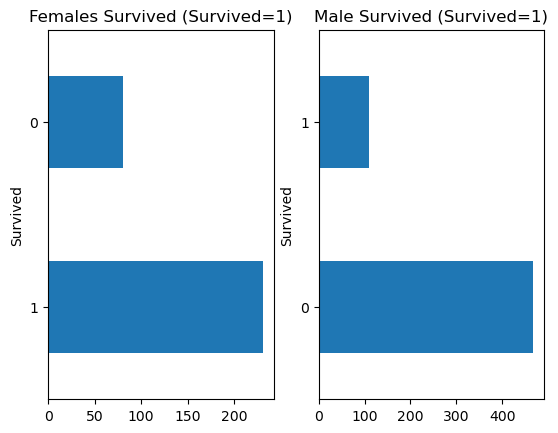

In [149]:
#Survival rate for Males and Females

fig, axs = plt.subplots(1,2)
train[train['Sex'] == 'female'].Survived.value_counts().plot(kind='barh', ax=axs[0], title="Females Survived (Survived=1)")
train[train['Sex'] == 'male'].Survived.value_counts().plot(kind='barh', ax=axs[1], title="Male Survived (Survived=1)");

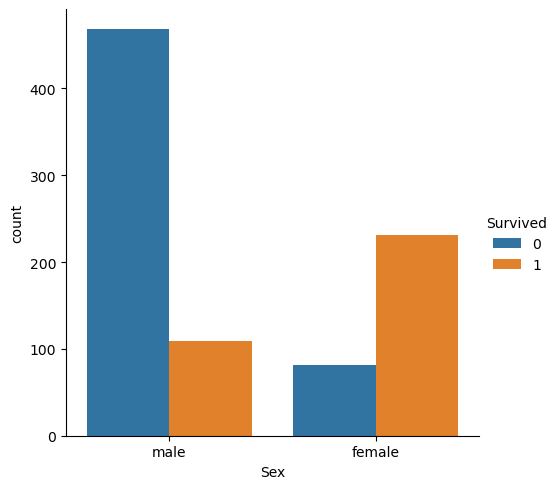

In [150]:
# Countplot for Males and Females survived
sns.catplot(x ="Sex", hue ="Survived",  
kind ="count", data = train);

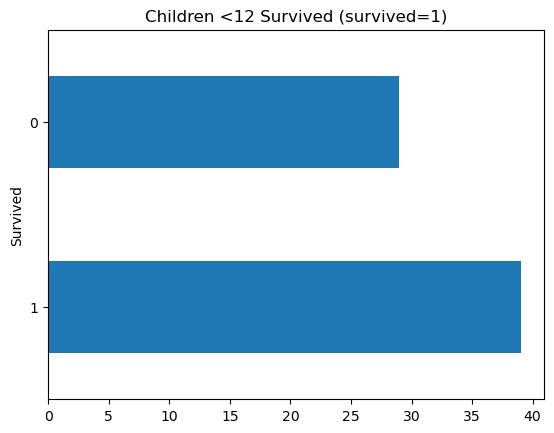

In [151]:
#Survival rate for Children <12 Years Old
train[train['Age'] <12].Survived.value_counts().plot(kind='barh', title="Children <12 Survived (survived=1)");

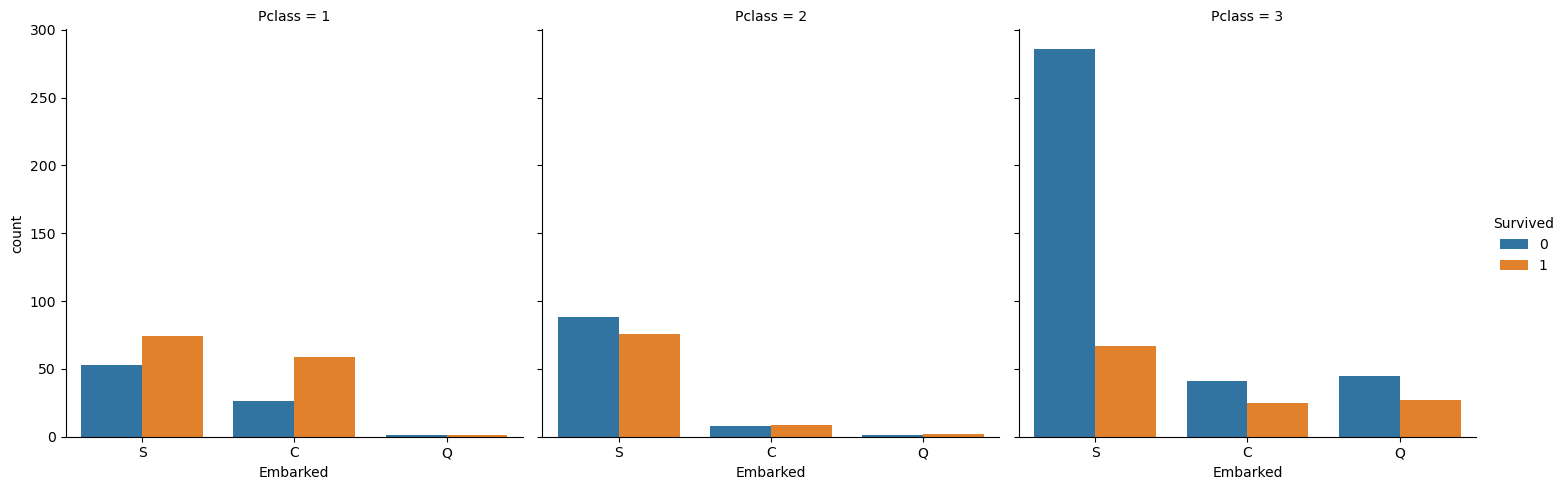

In [152]:
#count plot for embarked place, class and survival rate. Seems like 3rd class had the worst survival, who mostly embarked from S.
 
sns.catplot(x ='Embarked', hue ='Survived',  
kind ='count', col ='Pclass', data = train); 


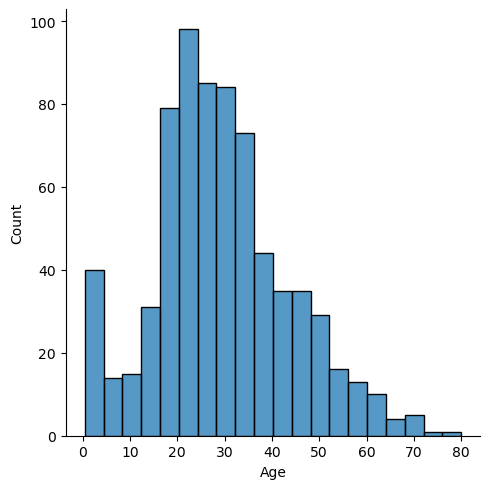

In [153]:
#Distribution of Age
sns.displot(train['Age']);

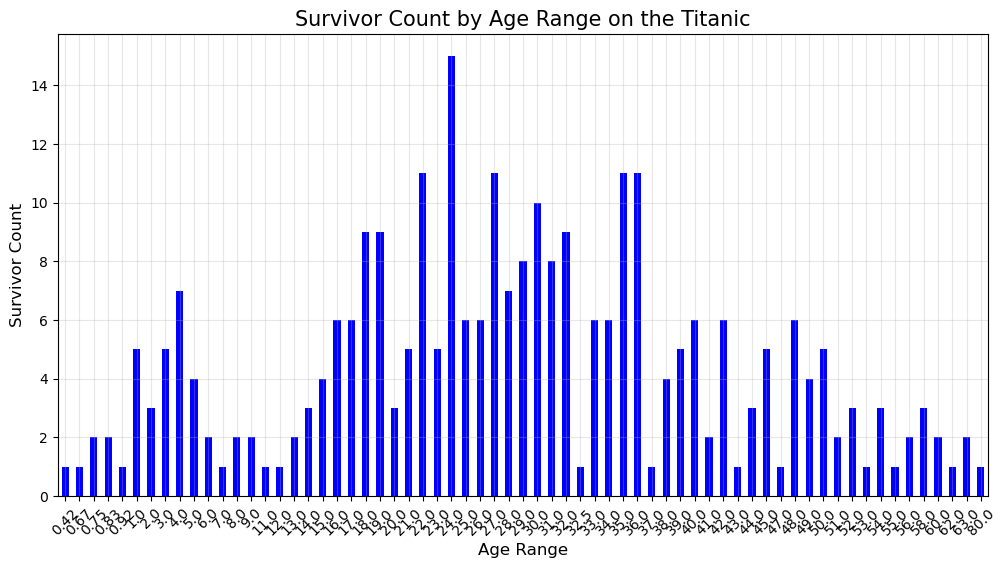

In [154]:
#survival rate for age : Mostly children under 8 and middle aged people survived 20-50s years old.

# Count the number of survivors for each age bin
age_bin_survivor_count = train[train['Survived'] == 1].groupby('Age')['Survived'].count()

# Plot the bar chart
plt.figure(figsize=(12, 6))
age_bin_survivor_count.plot(kind='bar', color='blue')
plt.title('Survivor Count by Age Range on the Titanic', fontsize=15)
plt.xlabel('Age Range', fontsize=12)
plt.ylabel('Survivor Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show();

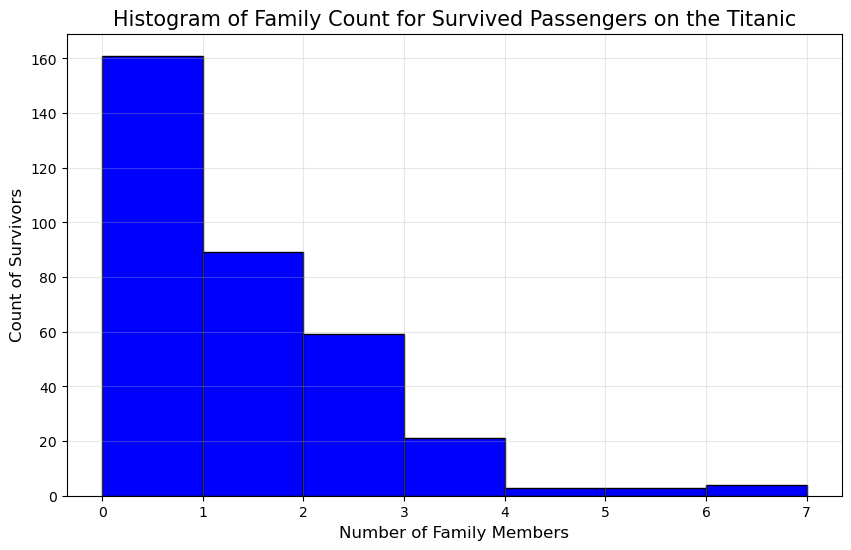

In [155]:
#survival rate for family

# Filter the DataFrame for survivors
survivors_train = train[train['Survived'] == 1]

#  histogram for FamilyCount
plt.figure(figsize=(10, 6))
plt.hist(survivors_train['FamilyCount'], bins=range(survivors_train['FamilyCount'].max() + 2), color='blue', edgecolor='black')
plt.title('Histogram of Family Count for Survived Passengers on the Titanic', fontsize=15)
plt.xlabel('Number of Family Members', fontsize=12)
plt.ylabel('Count of Survivors', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show();

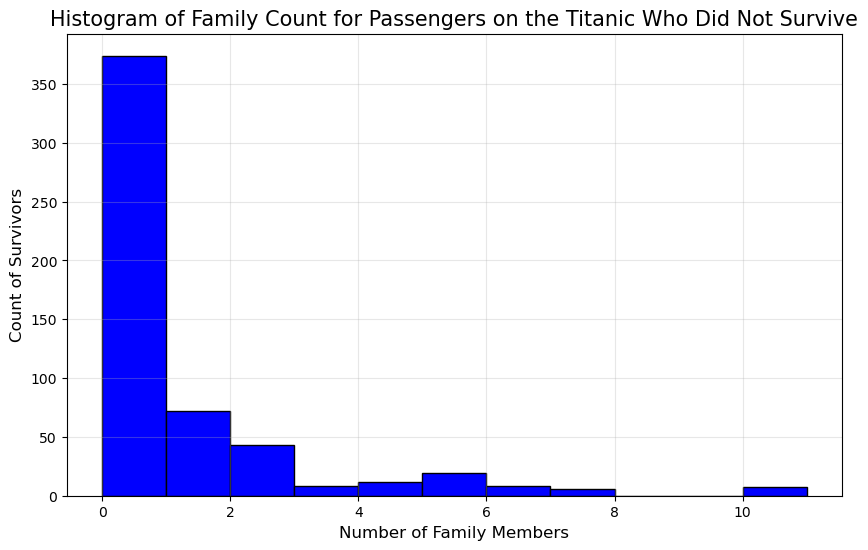

In [156]:
# Filter the DataFrame for survivors
survivors_train = train[train['Survived'] == 0]

#  histogram for FamilyCount
plt.figure(figsize=(10, 6))
plt.hist(survivors_train['FamilyCount'], bins=range(survivors_train['FamilyCount'].max() + 2), color='blue', edgecolor='black')
plt.title('Histogram of Family Count for Passengers on the Titanic Who Did Not Survive', fontsize=15)
plt.xlabel('Number of Family Members', fontsize=12)
plt.ylabel('Count of Survivors', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show();

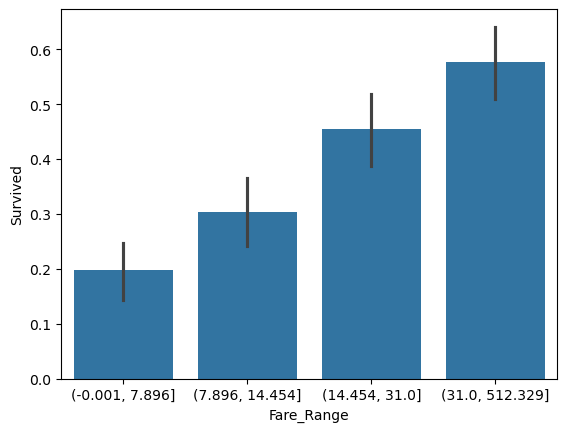

In [157]:
#survival rate for fare : seems like higher fares have higher survival rates.

# Divide Fare into 10 bins 
train['Fare_Range'] = pd.qcut(train['Fare'], 4)
sns.barplot(x ='Fare_Range', y ='Survived',  
data = train);